# Análisis de Clústering


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sys
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch


### Análisis de Agrupamiento de datos realizados


<small>

**Perfil básico de la víctima**
1. VICTIMA_EDAD
2. VICTIMA_ESCOLARIDAD

**Perfil ocupacional de la víctima**
1. VICTIMA_OCUP
2. VICTIMA_DEDICA
3. VICTIMA_TRABAJA

**Perfil básico del agresor**
1. AGRESOR_EDAD
2. AGRESOR_ESCOLARIDAD

**Perfil ocupacional del agresor**
1. AGRESOR_OCUP
2. AGRESOR_DEDICA
3. AGRESOR_TRABAJA

**Relación y tipo de agresión**
1. VICTIMA_RELACION_AGRESOR
2. HEC_TIPAGRE
3. VICTIMA_EDAD

**Contexto geográfico del hecho**
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO
3. VICTIMA_TRABAJA

</small>


### Cargar DataFrame


In [4]:
df = pd.read_csv("../CSV/UnidoPorAñoCSV/vif_all_years.csv")

C:\Users\diego\AppData\Local\Temp\ipykernel_18468\555449755.py:1: DtypeWarning: Columns (0,3,7,8,9,10,11,12,15,16,17,19,28,29,31,33,38,42,43,45,48,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../CSV/UnidoPorAñoCSV/vif_all_years.csv")


Análisis de Matriz de Correlación

In [5]:
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]


C:\Users\diego\AppData\Local\Temp\ipykernel_18468\23183120.py:14: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


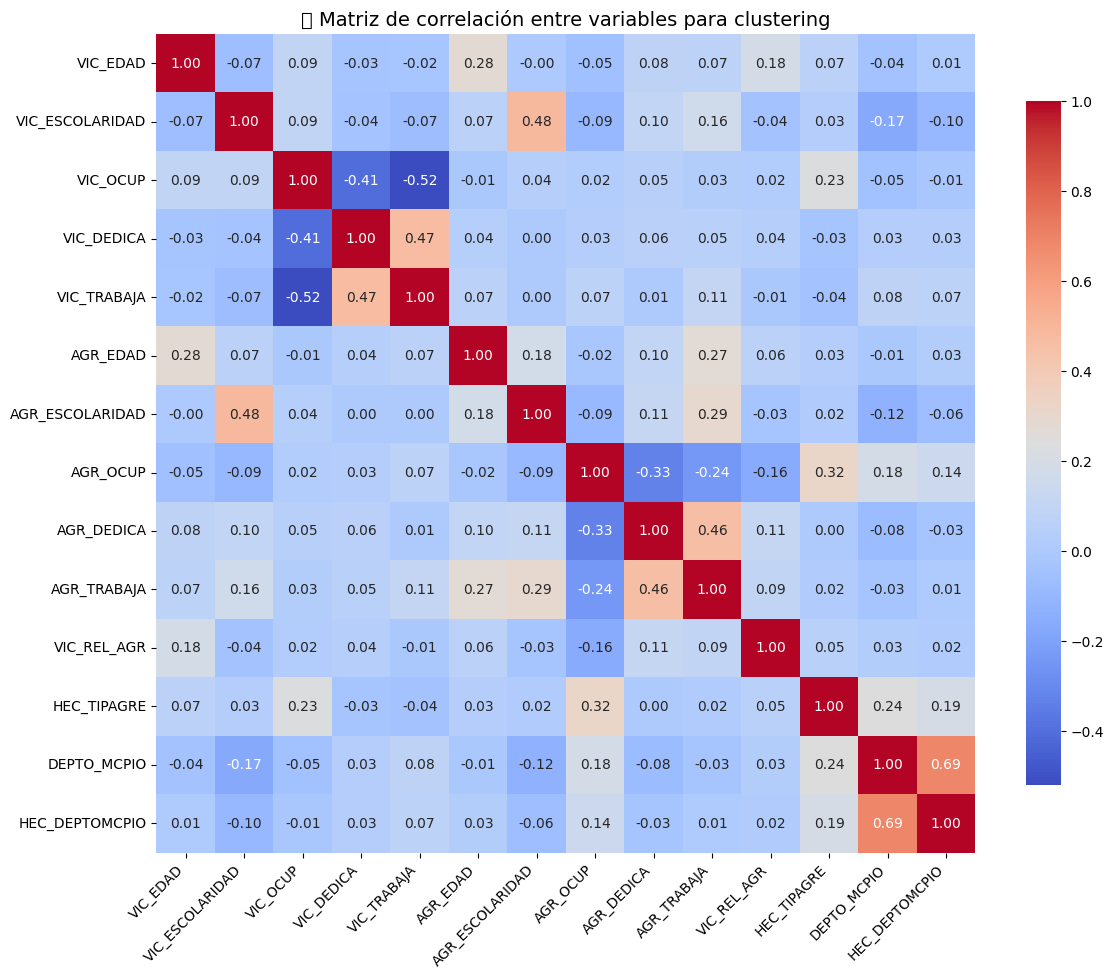

In [6]:
# Crear el mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
df_corr = df[columnas_para_clustering].apply(pd.to_numeric, errors='coerce').fillna(0)
sns.heatmap(
    df_corr.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("🔗 Matriz de correlación entre variables para clustering", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Análisis de la Matriz de Correlación

La matriz de correlación muestra, en general, **baja correlación** entre la mayoría de las variables. Esto es positivo para el análisis de clustering, ya que indica que cada variable aporta información distinta y relevante. A continuación, se destacan las correlaciones más notables:

- **VIC_OCUP** y **VIC_TRABAJA** (-0.52):  
  Sugiere que ciertos códigos de ocupación están fuertemente relacionados con no trabajar.

- **VIC_DEDICA** y **VIC_TRABAJA** (0.47):  
  Es lógico, ya que a mayor dedicación ocupacional, mayor probabilidad de estar trabajando.

- **AGR_TRABAJA** y **AGR_DEDICA** (0.46), y **AGR_OCUP** con **AGR_DEDICA** (-0.33):  
  Estas correlaciones son coherentes con los patrones laborales del agresor.

- **DEPTO_MCPIO** y **HEC_DEPTOMCPIO** (0.69):  
  Existe una alta correlación esperada, ya que ambas variables se refieren al lugar del hecho, posiblemente con codificación similar.

#### Observaciones adicionales:
- Las correlaciones entre las variables de la víctima y el agresor son **bajas o nulas**, lo cual respalda que sus perfiles puedan ser clusterizados por separado.
- La relación con el agresor (**VIC_REL_AGR**) no muestra una relación fuerte con ninguna otra variable, lo que indica que puede funcionar como una dimensión independiente de análisis.

Estas características refuerzan la utilidad de las variables seleccionadas para el análisis de clustering.



In [7]:
print(df_corr.corr())

                 VIC_EDAD  VIC_ESCOLARIDAD  VIC_OCUP  VIC_DEDICA  VIC_TRABAJA  \
VIC_EDAD         1.000000        -0.068554  0.092458   -0.031249    -0.024935   
VIC_ESCOLARIDAD -0.068554         1.000000  0.091352   -0.038570    -0.069843   
VIC_OCUP         0.092458         0.091352  1.000000   -0.405082    -0.520610   
VIC_DEDICA      -0.031249        -0.038570 -0.405082    1.000000     0.472630   
VIC_TRABAJA     -0.024935        -0.069843 -0.520610    0.472630     1.000000   
AGR_EDAD         0.279821         0.065050 -0.005835    0.043080     0.067339   
AGR_ESCOLARIDAD -0.000432         0.484293  0.040847    0.004838     0.002381   
AGR_OCUP        -0.054343        -0.092996  0.022430    0.032841     0.069066   
AGR_DEDICA       0.077451         0.101193  0.047560    0.058500     0.006777   
AGR_TRABAJA      0.071562         0.163471  0.026638    0.051890     0.107421   
VIC_REL_AGR      0.183864        -0.044391  0.020837    0.042535    -0.006531   
HEC_TIPAGRE      0.065463   

### Limpieza de Datos


In [8]:
# 🔽 1. Solo las columnas necesarias desde el inicio
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]

df_temp = df[columnas_para_clustering].copy()

# 🔽 2. Reemplazar solo en estas columnas (no en todo el DataFrame)
df_temp.replace('', pd.NA, inplace=True)
df_temp = df_temp.apply(pd.to_numeric, errors='coerce')
df_temp.fillna(0, inplace=True)

# 🔽 3. Escalar
scaler = StandardScaler()
df_clustering = scaler.fit_transform(df_temp)
df_ready = pd.DataFrame(df_clustering, columns=columnas_para_clustering)

# 🔽 4. Crear estrato sobre columnas discretas (¡no todas!)
columnas_para_estrato = [
    'VIC_ESCOLARIDAD', 'VIC_OCUP', 'VIC_TRABAJA',
    'AGR_ESCOLARIDAD', 'AGR_OCUP', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]
df_estrato = df_temp[columnas_para_estrato].astype(str)
df_temp["estrato"] = df_estrato.agg("_".join, axis=1)

# 🔽 5. Muestreo estratificado (con mínimo 1 por grupo)
df_sample = df_temp.groupby("estrato", group_keys=False).apply(
    lambda x: x.sample(n=min(max(1, int(len(x) * 0.05)), len(x)), random_state=42)
)

# 🔽 6. Subset del DataFrame escalado
df_ready_sample = df_ready.loc[df_sample.index]

# ✅ Vista previa
print(f"✅ Muestra creada: {df_ready_sample.shape}")
print(df_ready_sample.head())

C:\Users\diego\AppData\Local\Temp\ipykernel_18468\723451560.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_temp.groupby("estrato", group_keys=False).apply(


✅ Muestra creada: (384501, 14)
        VIC_EDAD  VIC_ESCOLARIDAD  VIC_OCUP  VIC_DEDICA  VIC_TRABAJA  \
340748 -1.950826        -1.777907 -0.589728   -0.754329    -2.362682   
335285 -1.883985        -1.777907 -0.589728   -0.754329    -2.362682   
368554 -1.883985        -1.777907 -0.589728   -0.754329    -2.362682   
373493 -2.151350        -1.777907 -0.589728   -0.754329    -2.362682   
247740 -1.950826        -1.777907 -0.589728   -0.754329    -2.362682   

        AGR_EDAD  AGR_ESCOLARIDAD  AGR_OCUP  AGR_DEDICA  AGR_TRABAJA  \
340748 -0.503922        -1.193678 -1.340524   -0.355105    -0.319226   
335285  3.131966        -1.193678 -1.340524   -0.355105    -0.319226   
368554 -1.646629        -1.193678 -1.340524    3.866329     0.327849   
373493  0.327138        -1.193678 -1.340524    0.113943     0.327849   
247740 -0.451981        -1.193678 -1.340524    3.866329     0.327849   

        VIC_REL_AGR  HEC_TIPAGRE  DEPTO_MCPIO  HEC_DEPTOMCPIO  
340748     0.245840    -2.007726    -1.

### Agrupamiento por clusters predichos


In [9]:
# Clustering del perfil básico de la víctima
grupo_perfil_victima = [
    "VIC_EDAD",
    "VIC_ESCOLARIDAD"
]

# Clustering del perfil ocupacional de la víctima
grupo_ocupacion_victima = [
    "VIC_OCUP",
    "VIC_DEDICA",
]

# Clustering del perfil básico del agresor
grupo_perfil_agresor = [
    "AGR_EDAD",
    "AGR_ESCOLARIDAD"
]

# Clustering del perfil ocupacional del agresor
grupo_ocupacion_agresor = [
    "AGR_OCUP",
    "AGR_DEDICA",
]

# Clustering de la relación y tipo de agresión
grupo_relacion_agresion = [
    "VIC_REL_AGR",
    "HEC_TIPAGRE",
    "VIC_EDAD"
]

# Clustering del contexto geográfico del hecho
grupo_contexto_geografico = [
    "DEPTO_MCPIO",
    "HEC_DEPTOMCPIO",
]

### Creación de DataFrames por Grupo


In [10]:
df_perfil_victima = df_ready[grupo_perfil_victima].dropna().copy()
df_ocupacion_victima = df_ready[grupo_ocupacion_victima].dropna().copy()
df_perfil_agresor = df_ready[grupo_perfil_agresor].dropna().copy()
df_ocupacion_agresor = df_ready[grupo_ocupacion_agresor].dropna().copy()
df_relacion_agresion = df_ready[grupo_relacion_agresion].dropna().copy()
df_contexto_geografico = df_ready[grupo_contexto_geografico].dropna().copy()

### Análisis de Hopkins


In [11]:
# Escalar los grupos 
df_perfil_victima_scaled = scale(df_perfil_victima)
df_ocupacion_victima_scaled = scale(df_ocupacion_victima)
df_perfil_agresor_scaled = scale(df_perfil_agresor)
df_ocupacion_agresor_scaled = scale(df_ocupacion_agresor)
df_relacion_agresion_scaled = scale(df_relacion_agresion)
df_contexto_geografico_scaled = scale(df_contexto_geografico)

In [12]:
# Calcular y mostrar estadístico de Hopkins por grupo
n_muestra = lambda x: min(15000, int(0.05 * len(x)))

print(f"Perfil víctima:         {hopkins(df_perfil_victima_scaled, n_muestra(df_perfil_victima_scaled))}")
print(f"Ocupación víctima:      {hopkins(df_ocupacion_victima_scaled, n_muestra(df_ocupacion_victima_scaled))}")
print(f"Perfil agresor:         {hopkins(df_perfil_agresor_scaled, n_muestra(df_perfil_agresor_scaled))}")
print(f"Ocupación agresor:      {hopkins(df_ocupacion_agresor_scaled, n_muestra(df_ocupacion_agresor_scaled))}")
print(f"Relación/agresión:      {hopkins(df_relacion_agresion_scaled, n_muestra(df_relacion_agresion_scaled))}")
print(f"Contexto geográfico:    {hopkins(df_contexto_geografico_scaled, n_muestra(df_contexto_geografico_scaled))}")


Perfil víctima:         0.00010789210428961675
Ocupación víctima:      1.560912879276508e-08
Perfil agresor:         8.650331881903947e-05
Ocupación agresor:      3.98227370406157e-08
Relación/agresión:      0.00018337571136903605
Contexto geográfico:    2.0705793512121783e-05


### Número de clusters adecuados con gráficas de codo


In [13]:
def elbow_plot_for_group(features, group_name):
    # Extraer subconjunto
    df_group = df_ready[features].copy()

    # Convertir a numérico y llenar NaNs con la mediana
    for col in features:
        df_group[col] = pd.to_numeric(df_group[col], errors='coerce')
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)

    # Normalizar
    X_scaled = scale(df_group)

    # Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f"Gráfico del Codo - {group_name}")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Suma de cuadrados intra-cluster (WCSS)")
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

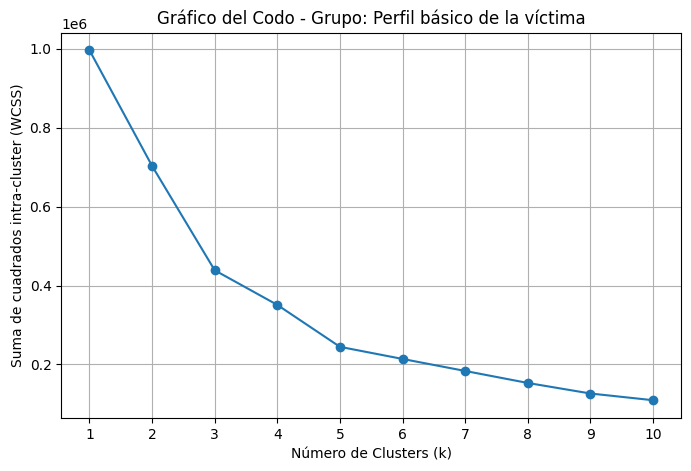

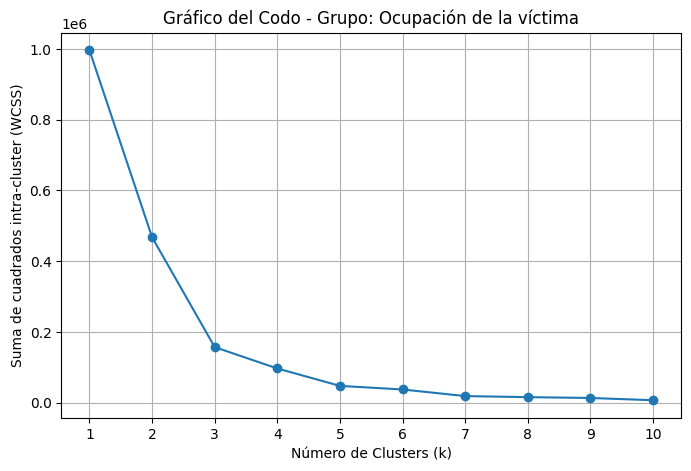

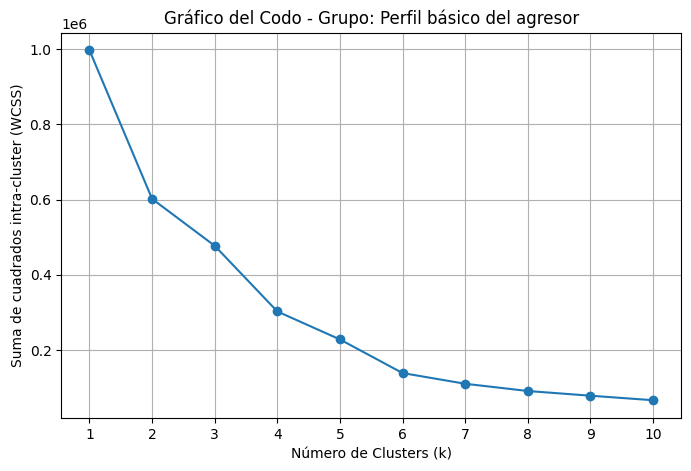

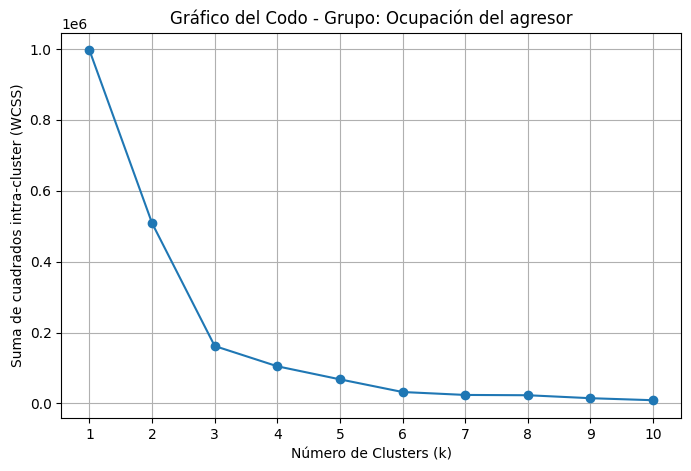

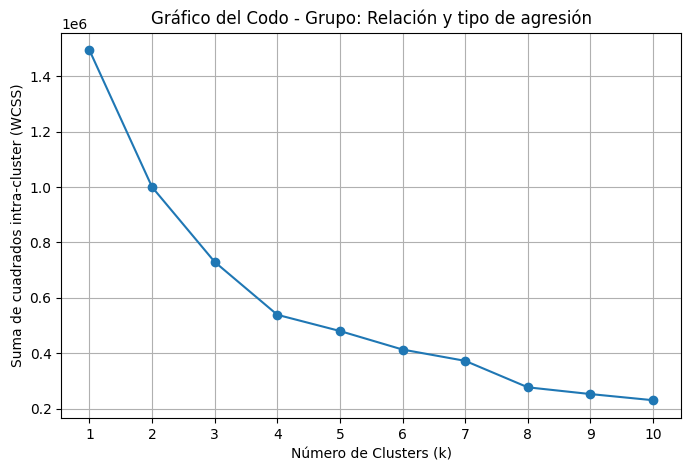

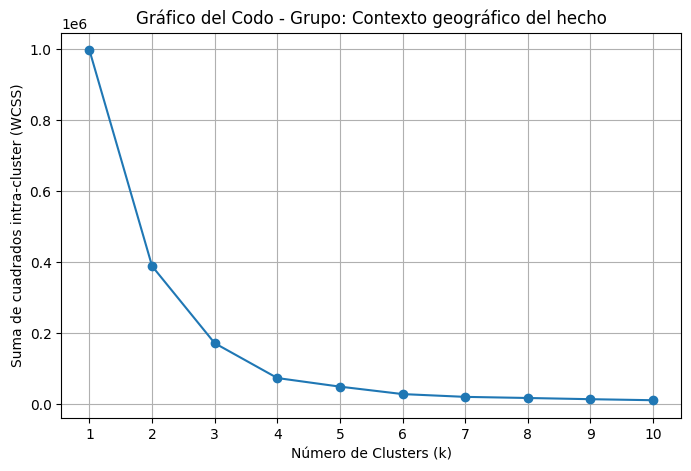

In [14]:
elbow_plot_for_group(grupo_perfil_victima, "Grupo: Perfil básico de la víctima")
elbow_plot_for_group(grupo_ocupacion_victima, "Grupo: Ocupación de la víctima")
elbow_plot_for_group(grupo_perfil_agresor, "Grupo: Perfil básico del agresor")
elbow_plot_for_group(grupo_ocupacion_agresor, "Grupo: Ocupación del agresor")
elbow_plot_for_group(grupo_relacion_agresion, "Grupo: Relación y tipo de agresión")
elbow_plot_for_group(grupo_contexto_geografico, "Grupo: Contexto geográfico del hecho")

En los seis gráficos, observamos una clara disminución de la suma de cuadrados intra-cluster (WCSS) al aumentar el número de clusters, pero el punto de inflexión —o "codo"— se identifica consistentemente en k = 3, especialmente en los grupos de ocupación de la víctima, ocupación del agresor y contexto geográfico del hecho, donde la curva se estabiliza notoriamente después de ese valor. Esto indica que tres clusters explican de forma eficiente la variabilidad en los datos, sin añadir complejidad innecesaria. En los grupos como perfil básico del agresor o relación y tipo de agresión, el descenso es más progresivo, pero aun así k = 3 sigue siendo un valor razonable, alineado con el análisis de silueta anterior. Este resultado refuerza que, para los fines de clasificación o segmentación, la elección de tres perfiles distintos por grupo es tanto válida como útil para describir los diferentes contextos y características sociodemográficas en los casos de violencia intrafamiliar.

## Clusters recomendados para cada grupo

<small>

### Clustering del perfil básico de la víctima (3 según análisis)
Variables:
1. VIC_EDAD
2. VIC_ESCOLARIDAD

### Clustering del perfil ocupacional de la víctima (3 según análisis)
Variables:
1. VIC_OCUP
2. VIC_DEDICA

### Clustering del perfil básico del agresor (2 según análisis)
Variables:
1. AGR_EDAD
2. AGR_ESCOLARIDAD

### Clustering del perfil ocupacional del agresor (3 según análisis)
Variables:
1. AGR_OCUP
2. AGR_DEDICA

### Clustering de la relación y tipo de agresión (2 según análisis)
Variables:
1. VIC_REL_AGR
2. HEC_TIPAGRE
3. VIC_EDAD

### Clustering del contexto geográfico del hecho (2 según análisis)
Variables:
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO

</small>


## Cálculo de K-Medias

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


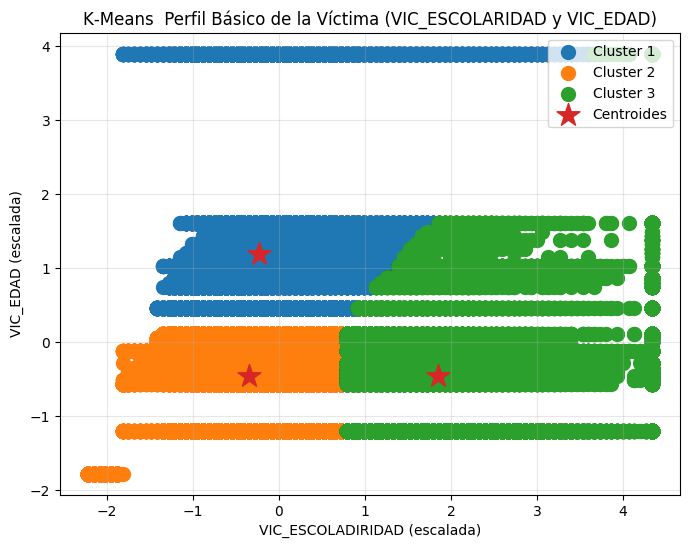

In [21]:
# -------------- GRUPO 1: Perfil Básico de la Víctima --------------


# Seleccionar sólo las dos columnas de interés
X_perfil_victima = df_perfil_victima_scaled

# Ajustar K‑Means
km_perfil_victima = KMeans(n_clusters=3, random_state=42).fit(X_perfil_victima)
labels_perfil_victima = km_perfil_victima.labels_
centroids_perfil_victima = km_perfil_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_perfil_victima == cluster)
    plt.scatter(X_perfil_victima[mask, 0],
                X_perfil_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_victima[:, 0],
            centroids_perfil_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means  Perfil Básico de la Víctima (VIC_ESCOLARIDAD y VIC_EDAD)")
plt.xlabel("VIC_ESCOLADIRIDAD (escalada)")
plt.ylabel("VIC_EDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gráfico muestra una segmentación clara en tres clusters bien diferenciados. Podemos observar lo siguiente:

- **Cluster 1 (azul):** Agrupa a víctimas con edad elevada y escolaridad media-baja, lo cual podría asociarse a personas adultas con estudios básicos o medios.

- **Cluster 2 (naranja):** Se concentra en víctimas jóvenes con baja escolaridad, lo que sugiere un perfil de alta vulnerabilidad educativa y posiblemente económica.

- **Cluster 3 (verde):** Reúne a víctimas con escolaridad alta pero edad más baja a intermedia, indicando posiblemente un grupo con mayor acceso educativo y potencialmente mayor conocimiento de rutas de denuncia.

Los centroides resaltados con estrellas rojas indican los valores medios representativos de cada grupo, confirmando una diferenciación tanto por nivel educativo como por etapa de vida. Este clustering es muy útil para diseñar estrategias diferenciadas de intervención y prevención, según el perfil sociodemográfico predominante.

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


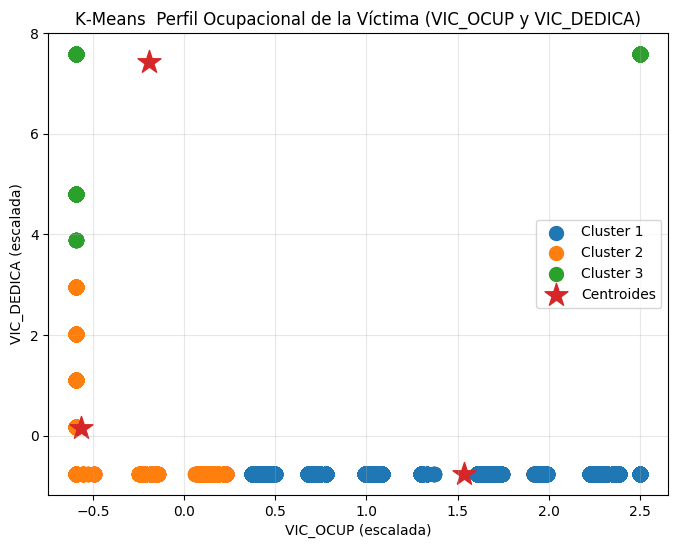

In [22]:
# -------------- GRUPO 2: Perfil Ocupacional de la Víctima --------------


# Seleccionar sólo las dos columnas de interés
X_ocupacion_victima = df_ocupacion_victima_scaled

# Ajustar K‑Means
km_ocupacion_victima = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_victima)
labels_ocupacion_victima = km_ocupacion_victima.labels_
centroids_ocupacion_victima = km_ocupacion_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_victima == cluster)
    plt.scatter(X_ocupacion_victima[mask, 0],
                X_ocupacion_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_victima[:, 0],
            centroids_ocupacion_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means  Perfil Ocupacional de la Víctima (VIC_OCUP y VIC_DEDICA)")
plt.xlabel("VIC_OCUP (escalada)")
plt.ylabel("VIC_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gráfico muestra tres clusters bien diferenciados en cuanto al tipo de ocupación y dedicación de las víctimas:

- **Cluster 1 (azul):** Agrupa principalmente a víctimas con ocupaciones más estables y variadas, pero con valores bajos en dedicación, lo que podría sugerir empleo parcial o informal.

- **Cluster 2 (naranja):** Se ubica en un rango inferior tanto en ocupación como en dedicación, representando probablemente a víctimas sin empleo definido o con escasa participación en actividades productivas.

- **Cluster 3 (verde):** Aunque pequeño y disperso, contiene a víctimas con altísima dedicación (valores atípicos), posiblemente personas que se dedican completamente a una ocupación informal, el hogar u otro tipo de actividad no estandarizada.

Los centroides (estrellas rojas) reflejan bien estas diferencias. Este patrón sugiere que el perfil ocupacional de la víctima podría tener relación con su nivel de exposición, acceso a redes de apoyo o decisiones sobre dónde y cómo denunciar.

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


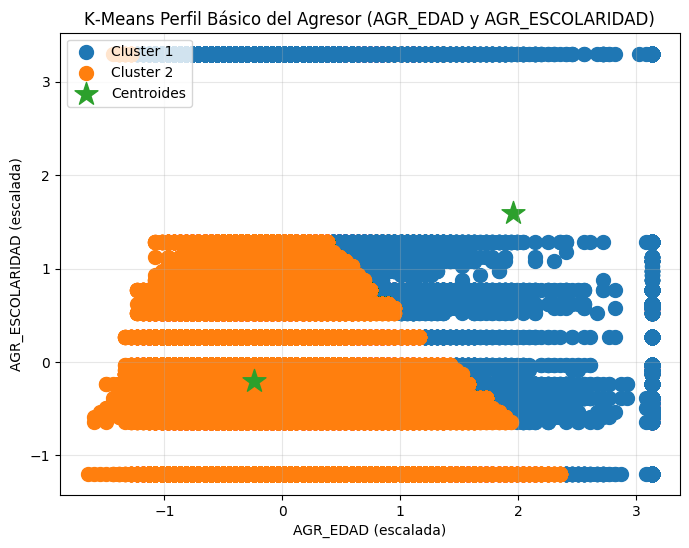

In [23]:
# -------------- GRUPO 3: Perfil Básico del Agresor --------------


# Seleccionar sólo las dos columnas de interés
X_perfil_agresor = df_perfil_agresor_scaled

# Ajustar K‑Means
km_perfil_agresor = KMeans(n_clusters=2, random_state=42).fit(X_perfil_agresor)
labels_perfil_agresor = km_perfil_agresor.labels_
centroids_perfil_agresor = km_perfil_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_perfil_agresor == cluster)
    plt.scatter(X_perfil_agresor[mask, 0],
                X_perfil_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_agresor[:, 0],
            centroids_perfil_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Perfil Básico del Agresor (AGR_EDAD y AGR_ESCOLARIDAD)")
plt.xlabel("AGR_EDAD (escalada)")
plt.ylabel("AGR_ESCOLARIDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Análisis del Clustering: Perfil Básico del Agresor

El clustering revela dos grupos bien diferenciados:

- **Cluster 1 (azul):** Representa agresores con edad más avanzada y mayor nivel educativo. Su concentración en la zona superior derecha sugiere adultos con cierto acceso a formación formal.

- **Cluster 2 (naranja):** Agrupa a agresores más jóvenes y con menor escolaridad, lo cual puede reflejar un perfil de mayor vulnerabilidad estructural y posiblemente más impulsividad o menor acceso a recursos.

Los centroides (estrellas verdes) validan esta segmentación y muestran cómo el factor educativo puede marcar una diferencia clara en combinación con la edad. Esto podría tener implicaciones tanto para el análisis del riesgo como para estrategias de intervención diferenciada.

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


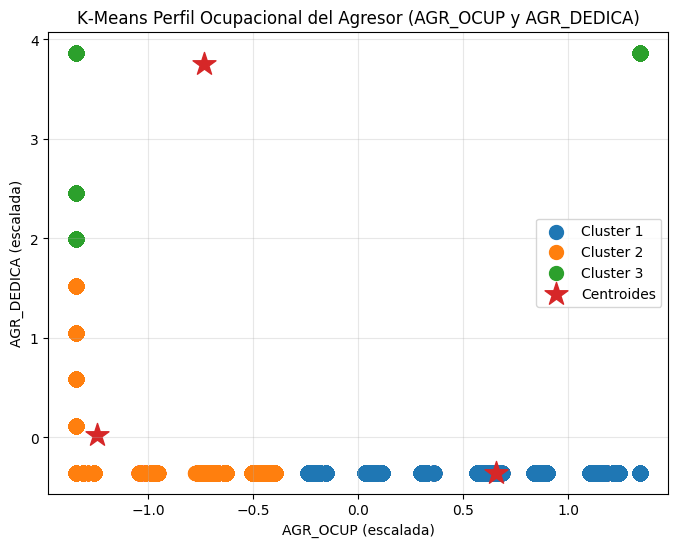

In [27]:
# -------------- GRUPO 5: Perfil Ocupacional del Agresor --------------

# Seleccionar sólo las dos columnas de interés
X_ocupacion_agresor = df_ocupacion_agresor_scaled

# Ajustar K‑Means
km_ocupacion_agresor = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_agresor)
labels_ocupacion_agresor = km_ocupacion_agresor.labels_
centroids_ocupacion_agresor = km_ocupacion_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_agresor == cluster)
    plt.scatter(X_ocupacion_agresor[mask, 0],
                X_ocupacion_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_agresor[:, 0],
            centroids_ocupacion_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Perfil Ocupacional del Agresor (AGR_OCUP y AGR_DEDICA)")
plt.xlabel("AGR_OCUP (escalada)")
plt.ylabel("AGR_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Análisis del Clustering: Perfil Ocupacional del Agresor

El gráfico muestra tres clusters bien definidos que reflejan diferentes combinaciones de ocupación y dedicación del agresor:

- **Cluster 1 (azul):** Representa a agresores con ocupaciones variadas pero baja dedicación, probablemente caracterizados por trabajos esporádicos o poco involucramiento en una actividad estable.

- **Cluster 2 (naranja):** Concentra agresores con ocupación muy baja o nula y también baja dedicación, lo cual puede asociarse a situaciones de desempleo o informalidad severa.

- **Cluster 3 (verde):** Destaca por valores extremadamente altos de dedicación, posiblemente agresores que se dedican intensamente a alguna actividad (formal o informal), pero que podrían representar casos atípicos o extremos dentro del conjunto.

Varianza explicada por PC1 y PC2 (Relación y tipo de agresión): [0.40508506 0.32308772]

Loadings (contribución de cada variable al PCA):
                   PC1       PC2
VIC_REL_AGR  0.653901 -0.297170
HEC_TIPAGRE  0.356934  0.932028
VIC_EDAD     0.667092 -0.207397


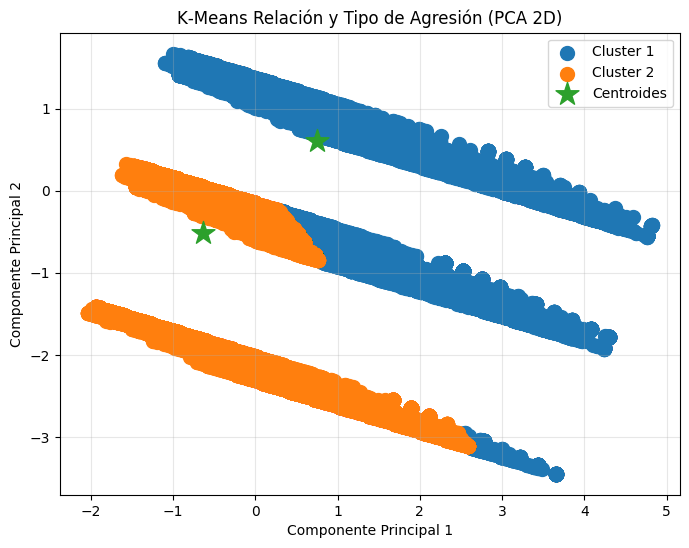

In [28]:
# -------------- GRUPO 5: Relación y Tipo de Agresión (PCA + KMeans) --------------

# Aplicar PCA a df_relacion_agresion_scaled (3 variables) para reducir a 2 dimensiones
pca_rel_agresion = PCA(n_components=2, random_state=42)
X_pca_rel_agresion = pca_rel_agresion.fit_transform(df_relacion_agresion_scaled)

# Mostrar varianza explicada por las 2 componentes principales
print("Varianza explicada por PC1 y PC2 (Relación y tipo de agresión):", pca_rel_agresion.explained_variance_ratio_)

# Mostrar tabla de loadings (contribución de cada variable al PCA)
loadings_rel_agresion = pd.DataFrame(
    pca_rel_agresion.components_.T,
    columns=["PC1", "PC2"],
    index=["VIC_REL_AGR", "HEC_TIPAGRE", "VIC_EDAD"]
)
print("\nLoadings (contribución de cada variable al PCA):\n", loadings_rel_agresion)

# Clustering K‑Means con 2 clusters (según análisis) sobre las componentes principales
km_rel_agresion = KMeans(n_clusters=2, random_state=42).fit(X_pca_rel_agresion)
labels_rel_agresion = km_rel_agresion.labels_
centroids_rel_agresion = km_rel_agresion.cluster_centers_

# Graficar los clusters en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_rel_agresion == cluster)
    plt.scatter(X_pca_rel_agresion[mask, 0],
                X_pca_rel_agresion[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')
plt.scatter(centroids_rel_agresion[:, 0],
            centroids_rel_agresion[:, 1],
            marker='*',
            s=300,
            label='Centroides')
plt.title("K‑Means Relación y Tipo de Agresión (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gráfico revela una separación clara entre dos clusters principales, lo cual indica que los tipos de relación víctima-agresor combinados con el tipo de agresión tienden a agruparse en dos patrones distintos de comportamiento:

- **Cluster 1 (azul):** Se ubica en la parte superior del gráfico PCA, sugiriendo un grupo con relaciones y agresiones posiblemente más directas o frecuentes, como parejas o familiares cercanos.

- **Cluster 2 (naranja):** Ocupa una región inferior, lo que puede representar situaciones menos convencionales o con dinámicas distintas de violencia, como agresiones por exparejas, conocidos o entornos más distantes.

La reducción a componentes principales conserva bien la estructura, y los centroides verdes confirman que ambos grupos están bien definidos y tienen una separación significativa. Esta diferenciación puede ser clave para diseñar protocolos diferenciados de atención y prevención según el tipo de vínculo y agresión reportada.

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


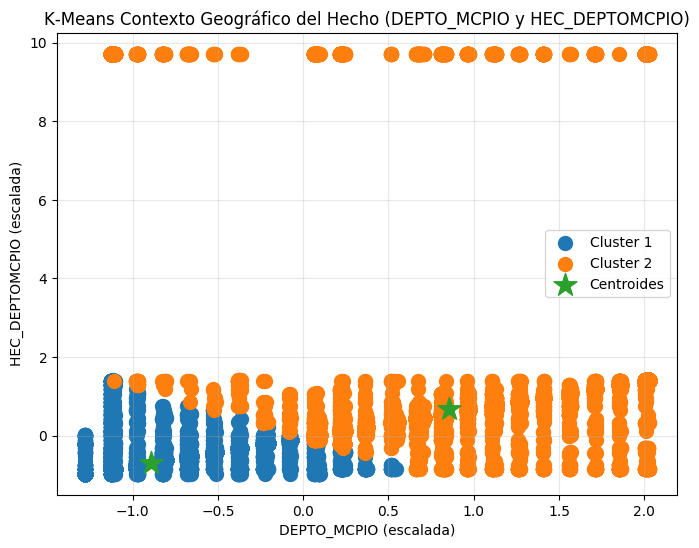

In [29]:
# -------------- GRUPO 6: Contexto Geográfico del Hecho --------------

# Seleccionar sólo las dos columnas de interés
X_contexto_geografico = df_contexto_geografico_scaled

# Ajustar K‑Means
km_contexto_geografico = KMeans(n_clusters=2, random_state=42).fit(X_contexto_geografico)
labels_contexto_geografico = km_contexto_geografico.labels_
centroids_contexto_geografico = km_contexto_geografico.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_contexto_geografico == cluster)
    plt.scatter(X_contexto_geografico[mask, 0],
                X_contexto_geografico[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_contexto_geografico[:, 0],
            centroids_contexto_geografico[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‑Means Contexto Geográfico del Hecho (DEPTO_MCPIO y HEC_DEPTOMCPIO)")
plt.xlabel("DEPTO_MCPIO (escalada)")
plt.ylabel("HEC_DEPTOMCPIO (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Análisis del Clustering: Contexto Geográfico del Hecho

El gráfico presenta dos clusters principales que reflejan diferencias en la ubicación geográfica donde ocurre el hecho versus el lugar donde se denuncia:

- **Cluster 1 (azul):** Se concentra en valores bajos de ambas variables, lo que puede sugerir hechos y denuncias localizadas en zonas más cercanas o menos dispersas geográficamente (probablemente áreas rurales o departamentos con menor movilidad).

- **Cluster 2 (naranja):** Se extiende hacia valores más altos, en especial en `HEC_DEPTOMCPIO`, lo que indica una mayor dispersión en los lugares donde ocurren los hechos y se denuncian, posiblemente reflejando desplazamiento entre el lugar del hecho y la denuncia o mayor dinamismo urbano.

Los centroides (estrellas verdes) muestran que la segmentación espacial tiene sentido y puede ser útil para analizar flujos territoriales de denuncia, lo cual podría guiar decisiones sobre distribución de recursos institucionales (como comisarías o fiscalías móviles).